# Project 3: Surgical Outcomes & Cardiovascular Risk
## NLP on Clinical Notes + Structured Data Fusion

---

**Objective:** Build an NLP pipeline to extract clinical comorbidities from surgical notes, then fuse those extracted features with structured heart disease data to predict cardiovascular risk in surgical patients.

**Core Question:** Does parsing clinical notes add predictive value beyond structured data alone?

**Datasets:**
- Anesthesia Dataset (300 patients) — surgical records with free-text clinical notes
- Heart Disease UCI (920 patients) — structured cardiovascular risk factors

---

### Executive Summary
*(Fill this in after completing the project)*

- **Problem:**
- **Approach:**
- **NLP Extraction Accuracy (F1):**
- **NLP Uplift (AUC improvement):**
- **Key Finding:**
- **Limitations:**

In [1]:
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, accuracy_score
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Set plot defaults
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')

# Set random seeds
random.seed(42)
np.random.seed(42)

In [2]:
# Load both datasets
anes = pd.read_csv('Anesthesia_Dataset.csv')
heart = pd.read_csv('heart_disease_uci.csv')

print("=== ANESTHESIA DATASET ===")
print(f"Shape: {anes.shape}")
print(f"Columns: {anes.shape[1]}")
print(f"Memory usage: {anes.memory_usage(deep=True).sum() / 1024:.2f} KB")

print("\n=== HEART DISEASE DATASET ===")
print(f"Shape: {heart.shape}")
print(f"Columns: {heart.shape[1]}")
print(f"Memory usage: {heart.memory_usage(deep=True).sum() / 1024:.2f} KB")

=== ANESTHESIA DATASET ===
Shape: (300, 12)
Columns: 12
Memory usage: 135.98 KB

=== HEART DISEASE DATASET ===
Shape: (920, 16)
Columns: 16
Memory usage: 413.63 KB


In [3]:
# Anesthesia Dataset Overview
print("=== ANESTHESIA DATASET OVERVIEW ===\n")

print("Data Types:")
print(anes.dtypes)

print("\n\nMissing Values (only columns with missing data):")
missing_counts = anes.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
if len(missing_counts) > 0:
    print(missing_counts)
else:
    print("No missing values")

print("\n\nFirst 5 rows:")
print(anes.head())

=== ANESTHESIA DATASET OVERVIEW ===

Data Types:
PatientID             int64
Age                   int64
Gender                  str
BMI                   int64
SurgeryType             str
SurgeryDuration         str
AnesthesiaType          str
PreoperativeNotes       str
PostoperativeNotes      str
PainLevel             int64
Complications           str
Outcome               int64
dtype: object


Missing Values (only columns with missing data):
Complications    73
dtype: int64


First 5 rows:
   PatientID  Age Gender  BMI     SurgeryType SurgeryDuration AnesthesiaType  \
0          1   33      M   32    Neurological         217 min          Local   
1          2   33      M   23  Cardiovascular         181 min          Local   
2          3   58      F   24      Orthopedic          79 min        General   
3          4   65      F   26      Orthopedic         210 min          Local   
4          5   65      M   28    Neurological         221 min        General   

        Preoperative

In [4]:
# Heart Disease Dataset Overview
print("=== HEART DISEASE DATASET OVERVIEW ===\n")

print("Data Types:")
print(heart.dtypes)

print("\n\nMissing Values (only columns with missing data, sorted ascending):")
missing_counts = heart.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=True)
if len(missing_counts) > 0:
    print(missing_counts)
    total_missing = missing_counts.sum()
    total_cells = heart.shape[0] * heart.shape[1]
    missing_pct = (total_missing / total_cells) * 100
    print(f"\nOverall missing: {total_missing} cells out of {total_cells} ({missing_pct:.2f}%)")
else:
    print("No missing values")

print("\n\nFirst 5 rows:")
print(heart.head())

=== HEART DISEASE DATASET OVERVIEW ===

Data Types:
id            int64
age           int64
sex             str
dataset         str
cp              str
trestbps    float64
chol        float64
fbs          object
restecg         str
thalch      float64
exang        object
oldpeak     float64
slope           str
ca          float64
thal            str
num           int64
dtype: object


Missing Values (only columns with missing data, sorted ascending):
restecg       2
chol         30
exang        55
thalch       55
trestbps     59
oldpeak      62
fbs          90
slope       309
thal        486
ca          611
dtype: int64

Overall missing: 1759 cells out of 14720 (11.95%)


First 5 rows:
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   3

### 🔍 Critical Discovery — Examine the Text Fields

Run the cells below and document what you find. How many unique values does each text column have?

In [5]:
# Examine text columns
print("=== PREOPERATIVE NOTES ===")
print(f"Unique values: {anes['PreoperativeNotes'].nunique()}")
print("\nValue counts:")
print(anes['PreoperativeNotes'].value_counts())

print("\n\n=== POSTOPERATIVE NOTES ===")
print(f"Unique values: {anes['PostoperativeNotes'].nunique()}")
print("\nValue counts:")
print(anes['PostoperativeNotes'].value_counts())

print("\n\n=== COMPLICATIONS ===")
print(f"Unique values (including NaN): {anes['Complications'].nunique()}")
missing_comp = anes['Complications'].isnull().sum()
missing_comp_pct = (missing_comp / len(anes)) * 100
print(f"Missing count: {missing_comp} ({missing_comp_pct:.1f}%)")
print("\nValue counts (non-null):")
print(anes['Complications'].value_counts())

=== PREOPERATIVE NOTES ===
Unique values: 2

Value counts:
PreoperativeNotes
Hypertension, diabetes    157
Stable, no allergies      143
Name: count, dtype: int64


=== POSTOPERATIVE NOTES ===
Unique values: 2

Value counts:
PostoperativeNotes
Minimal pain, no complications    152
Pain, slow recovery               148
Name: count, dtype: int64


=== COMPLICATIONS ===
Unique values (including NaN): 3
Missing count: 73 (24.3%)

Value counts (non-null):
Complications
Respiratory distress     83
Nausea, mild bleeding    80
Delayed recovery         64
Name: count, dtype: int64


In [6]:
# Feature overlap analysis
print("=== AGE RANGES ===")
print(f"Anesthesia Age: min={anes['Age'].min()}, max={anes['Age'].max()}, mean={anes['Age'].mean():.1f}")
print(f"Heart Disease Age: min={heart['age'].min()}, max={heart['age'].max()}, mean={heart['age'].mean():.1f}")

overlap_min = max(anes['Age'].min(), heart['age'].min())
overlap_max = min(anes['Age'].max(), heart['age'].max())
print(f"Overlap range: {overlap_min} to {overlap_max} years")

print("\n\n=== FEATURE MAPPING ===")
# Build feature mapping DataFrame
mapping_data = [
    {
        'Anesthesia Feature': 'Age',
        'Anesthesia Description': 'Patient age (years)',
        'Heart Disease Feature': 'age',
        'Heart Disease Description': 'Patient age (years)',
        'Match Type': 'Direct match'
    },
    {
        'Anesthesia Feature': 'BMI',
        'Anesthesia Description': 'Body Mass Index',
        'Heart Disease Feature': '—',
        'Heart Disease Description': 'Not available',
        'Match Type': 'No match'
    },
    {
        'Anesthesia Feature': 'PreoperativeNotes (Hypertension)',
        'Anesthesia Description': 'Clinical indicator of hypertension',
        'Heart Disease Feature': 'trestbps',
        'Heart Disease Description': 'Resting blood pressure (mmHg)',
        'Match Type': 'Related but indirect'
    },
    {
        'Anesthesia Feature': 'PreoperativeNotes (diabetes)',
        'Anesthesia Description': 'Clinical indicator of diabetes',
        'Heart Disease Feature': 'fbs',
        'Heart Disease Description': 'Fasting blood sugar > 120 mg/dl (binary)',
        'Match Type': 'Related but indirect'
    },
    {
        'Anesthesia Feature': 'SurgeryType (Cardiovascular)',
        'Anesthesia Description': 'Indicates cardiac surgery',
        'Heart Disease Feature': 'num',
        'Heart Disease Description': 'Presence/severity of heart disease (0-4)',
        'Match Type': 'Related outcome'
    }
]

mapping_df = pd.DataFrame(mapping_data)
print(mapping_df.to_string(index=False))

=== AGE RANGES ===
Anesthesia Age: min=33, max=72, mean=54.2
Heart Disease Age: min=28, max=77, mean=53.5
Overlap range: 33 to 72 years


=== FEATURE MAPPING ===
              Anesthesia Feature             Anesthesia Description Heart Disease Feature                Heart Disease Description           Match Type
                             Age                Patient age (years)                   age                      Patient age (years)         Direct match
                             BMI                    Body Mass Index                     —                            Not available             No match
PreoperativeNotes (Hypertension) Clinical indicator of hypertension              trestbps            Resting blood pressure (mmHg) Related but indirect
    PreoperativeNotes (diabetes)     Clinical indicator of diabetes                   fbs Fasting blood sugar > 120 mg/dl (binary) Related but indirect
    SurgeryType (Cardiovascular)          Indicates cardiac surgery           

### ✏️ Your Observations

**What did you discover about the text columns?**

*Write your observations here:*
- PreoperativeNotes has only ___ unique values: ...
- PostoperativeNotes has only ___ unique values: ...
- This means that for NLP to be meaningful, we'll need to...


---
## Step 2 — Clean the Structured Data

Before we touch the text, let's get the structured data into shape.

### Anesthesia Dataset Cleaning

In [7]:
# Prompt for Claude Code:
#
# Clean the anesthesia dataset (3 code cells):
#
# 2a. Parse SurgeryDuration (string like '217 min') into hours.
#     Create `duration_hours` = extracted integer / 60.
#     Print before/after examples and the range in hours.
#
# 2b. Handle 73 missing Complications values:
#     Create `has_complications` = 1 if Complications is not null, 0 otherwise.
#     Create `complication_type` = original value filled with 'None' for NaN.
#     Print the distribution of has_complications.
#
# 2c. Encode categoricals:
#     - `gender_encoded`: 1 if Gender == 'M', else 0
#     - `anesthesia_general`: 1 if AnesthesiaType == 'General', else 0
#     - One-hot encode SurgeryType using pd.get_dummies with prefix='surgery'
#       (this creates columns: surgery_Cardiovascular, surgery_Cosmetic,
#        surgery_Neurological, surgery_Orthopedic)
#     Concatenate the dummies onto the anes DataFrame. Print the new columns.

In [8]:
# 2a. Parse SurgeryDuration string into hours
print("=== PARSING SURGERY DURATION ===")

# Before
print("Before:")
print(anes['SurgeryDuration'].head(10))
print(f"Data type: {anes['SurgeryDuration'].dtype}")

# Extract integer from string and convert to hours
anes['duration_hours'] = anes['SurgeryDuration'].str.extract(r'(\d+)').astype(float) / 60

# After
print("\n\nAfter (duration_hours):")
print(anes['duration_hours'].head(10))
print(f"\nRange: {anes['duration_hours'].min():.2f} to {anes['duration_hours'].max():.2f} hours")
print(f"Mean: {anes['duration_hours'].mean():.2f} hours")
print(f"Median: {anes['duration_hours'].median():.2f} hours")

=== PARSING SURGERY DURATION ===
Before:
0    217 min
1    181 min
2     79 min
3    210 min
4    221 min
5     82 min
6     96 min
7    210 min
8    226 min
9    207 min
Name: SurgeryDuration, dtype: str
Data type: str


After (duration_hours):
0    3.616667
1    3.016667
2    1.316667
3    3.500000
4    3.683333
5    1.366667
6    1.600000
7    3.500000
8    3.766667
9    3.450000
Name: duration_hours, dtype: float64

Range: 1.00 to 4.00 hours
Mean: 2.46 hours
Median: 2.48 hours


In [9]:
# 2b. Handle missing Complications values
print("=== HANDLING MISSING COMPLICATIONS ===")

# Create binary flag for any complications
anes['has_complications'] = (anes['Complications'].notna()).astype(int)

# Create complication_type with 'None' for missing values
anes['complication_type'] = anes['Complications'].fillna('None')

print("\nDistribution of has_complications:")
print(anes['has_complications'].value_counts().sort_index())
print(f"\nPercentage with complications: {anes['has_complications'].mean()*100:.1f}%")

print("\n\nComplication types:")
print(anes['complication_type'].value_counts())

=== HANDLING MISSING COMPLICATIONS ===

Distribution of has_complications:
has_complications
0     73
1    227
Name: count, dtype: int64

Percentage with complications: 75.7%


Complication types:
complication_type
Respiratory distress     83
Nausea, mild bleeding    80
None                     73
Delayed recovery         64
Name: count, dtype: int64


In [10]:
# 2c. Encode categorical variables
print("=== ENCODING CATEGORICAL VARIABLES ===")

# Gender encoding: 1 if 'M', 0 otherwise
anes['gender_encoded'] = (anes['Gender'] == 'M').astype(int)
print("Gender encoding:")
print(f"  M (Male) → 1: {(anes['gender_encoded'] == 1).sum()} patients")
print(f"  F (Female) → 0: {(anes['gender_encoded'] == 0).sum()} patients")

# Anesthesia type encoding: 1 if 'General', 0 otherwise
anes['anesthesia_general'] = (anes['AnesthesiaType'] == 'General').astype(int)
print("\n\nAnesthesia type encoding:")
print(f"  General → 1: {(anes['anesthesia_general'] == 1).sum()} procedures")
print(f"  Other (Regional/Local) → 0: {(anes['anesthesia_general'] == 0).sum()} procedures")

# One-hot encode SurgeryType
surgery_dummies = pd.get_dummies(anes['SurgeryType'], prefix='surgery')
print("\n\nSurgery type one-hot encoding:")
print(surgery_dummies.columns.tolist())
print(surgery_dummies.head())

# Concatenate onto anes
anes = pd.concat([anes, surgery_dummies], axis=1)

print("\n\nNew columns added:")
print([col for col in surgery_dummies.columns])
print(f"\nTotal anes columns now: {anes.shape[1]}")
print(f"Total anes rows: {anes.shape[0]}")

=== ENCODING CATEGORICAL VARIABLES ===
Gender encoding:
  M (Male) → 1: 155 patients
  F (Female) → 0: 145 patients


Anesthesia type encoding:
  General → 1: 149 procedures
  Other (Regional/Local) → 0: 151 procedures


Surgery type one-hot encoding:
['surgery_Cardiovascular', 'surgery_Cosmetic', 'surgery_Neurological', 'surgery_Orthopedic']
   surgery_Cardiovascular  surgery_Cosmetic  surgery_Neurological  \
0                   False             False                  True   
1                    True             False                 False   
2                   False             False                 False   
3                   False             False                 False   
4                   False             False                  True   

   surgery_Orthopedic  
0               False  
1               False  
2                True  
3                True  
4               False  


New columns added:
['surgery_Cardiovascular', 'surgery_Cosmetic', 'surgery_Neurological', 'sur

### Heart Dataset Cleaning

In [11]:
# Prompt for Claude Code:
#
# Clean the heart dataset (4 code cells):
#
# Prepare the code for the following tasks for me to paste into the notebook
#
# 2d. Fix fbs and exang columns — they contain BOTH string 'True'/'False'
#     AND boolean True/False. Map all values to integer 1/0.
#     Print before/after dtype and value counts for fbs.
#
# 2e. Replace cholesterol (chol) zeros with NaN (biologically impossible).
#     Print zero count before and missing count after.
#
# 2f. Impute missing values:
#     - Numeric columns [trestbps, chol, thalch, oldpeak, ca] → median
#     - Categorical columns [fbs, exang, restecg, slope, thal] → mode
#     Print which columns were filled and with what value.
#
# 2g. Create binary target: `has_heart_disease` = (num > 0).astype(int).
#     Encode sex: `sex_encoded` = 1 if sex == 'Male', else 0.
#     LabelEncode columns [cp, restecg, slope, thal] → new col named
#     col + '_encoded' (e.g., cp_encoded). Store encoders in a dict.
#     Drop columns 'id' and 'dataset'.
#     Print final shape and remaining missing count.

In [12]:
# 2d. Fix fbs and exang columns (mixed string/boolean types)
print("=== FIXING FBS AND EXANG COLUMNS ===")

print("Before:")
print(f"fbs dtype: {heart['fbs'].dtype}")
print(f"fbs value_counts:\n{heart['fbs'].value_counts(dropna=False)}")

# Map all values (string 'True'/'False' and boolean True/False) to 1/0
heart['fbs'] = heart['fbs'].astype(str).map({'True': 1, 'False': 0, '1': 1, '0': 0})
heart['exang'] = heart['exang'].astype(str).map({'True': 1, 'False': 0, '1': 1, '0': 0})

print("\n\nAfter:")
print(f"fbs dtype: {heart['fbs'].dtype}")
print(f"fbs value_counts:\n{heart['fbs'].value_counts(dropna=False)}")

print(f"\nexang dtype: {heart['exang'].dtype}")
print(f"exang value_counts:\n{heart['exang'].value_counts(dropna=False)}")


=== FIXING FBS AND EXANG COLUMNS ===
Before:
fbs dtype: object
fbs value_counts:
fbs
False    692
True     138
NaN       90
Name: count, dtype: int64


After:
fbs dtype: float64
fbs value_counts:
fbs
0.0    692
1.0    138
NaN     90
Name: count, dtype: int64

exang dtype: float64
exang value_counts:
exang
0.0    528
1.0    337
NaN     55
Name: count, dtype: int64


In [13]:
# 2e. Replace cholesterol zeros with NaN (biologically impossible)
print("=== FIXING CHOLESTEROL ZEROS ===")

zero_count_before = (heart['chol'] == 0).sum()
print(f"Cholesterol zero count before: {zero_count_before}")

# Replace zeros with NaN
heart.loc[heart['chol'] == 0, 'chol'] = np.nan

missing_count_after = heart['chol'].isnull().sum()
print(f"Cholesterol missing count after: {missing_count_after}")

=== FIXING CHOLESTEROL ZEROS ===
Cholesterol zero count before: 172
Cholesterol missing count after: 202


In [15]:
# 2f. Impute missing values
print("=== IMPUTING MISSING VALUES ===")

# Numeric columns → median
numeric_cols = ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
imputer_numeric = SimpleImputer(strategy='median')
heart[numeric_cols] = imputer_numeric.fit_transform(heart[numeric_cols])

print("Numeric columns imputed with median:")
for col, val in zip(numeric_cols, imputer_numeric.statistics_):
    print(f"  {col}: {val:.1f}")

# Categorical columns → mode
categorical_cols = ['fbs', 'exang', 'restecg', 'slope', 'thal']
imputer_categorical = SimpleImputer(strategy='most_frequent')
heart[categorical_cols] = imputer_categorical.fit_transform(heart[categorical_cols])

print("\n\nCategorical columns imputed with mode:")
for col, val in zip(categorical_cols, imputer_categorical.statistics_):
    print(f"  {col}: {val}")

print(f"\n\nRemaining missing values in heart dataset: {heart.isnull().sum().sum()}")

=== IMPUTING MISSING VALUES ===
Numeric columns imputed with median:
  trestbps: 130.0
  chol: 239.5
  thalch: 140.0
  oldpeak: 0.5
  ca: 0.0


Categorical columns imputed with mode:
  fbs: 0.0
  exang: 0.0
  restecg: normal
  slope: flat
  thal: normal


Remaining missing values in heart dataset: 0


In [16]:
# 2g. Create binary target, encode sex and categorical columns
print("=== CREATING TARGET AND ENCODING ===")

# Create binary target: has_heart_disease = (num > 0)
heart['has_heart_disease'] = (heart['num'] > 0).astype(int)
print("Target variable (has_heart_disease):")
print(heart['has_heart_disease'].value_counts())

# Encode sex: 1 if 'Male', 0 otherwise
heart['sex_encoded'] = (heart['sex'] == 'Male').astype(int)
print(f"\n\nGender encoding:")
print(f"  Male → 1: {(heart['sex_encoded'] == 1).sum()}")
print(f"  Female → 0: {(heart['sex_encoded'] == 0).sum()}")

# LabelEncode categorical columns
label_encoders = {}
cols_to_encode = ['cp', 'restecg', 'slope', 'thal']

for col in cols_to_encode:
    le = LabelEncoder()
    heart[f'{col}_encoded'] = le.fit_transform(heart[col])
    label_encoders[col] = le
    print(f"\n{col} label encoding:")
    for i, label in enumerate(le.classes_):
        print(f"  {label} → {i}")

# Drop original columns
heart = heart.drop(columns=['id', 'dataset'])

print(f"\n\nFinal shape: {heart.shape}")
print(f"Final missing count: {heart.isnull().sum().sum()}")

=== CREATING TARGET AND ENCODING ===
Target variable (has_heart_disease):
has_heart_disease
1    509
0    411
Name: count, dtype: int64


Gender encoding:
  Male → 1: 726
  Female → 0: 194

cp label encoding:
  asymptomatic → 0
  atypical angina → 1
  non-anginal → 2
  typical angina → 3

restecg label encoding:
  lv hypertrophy → 0
  normal → 1
  st-t abnormality → 2

slope label encoding:
  downsloping → 0
  flat → 1
  upsloping → 2

thal label encoding:
  fixed defect → 0
  normal → 1
  reversable defect → 2


Final shape: (920, 20)
Final missing count: 0


### ✏️ Cleaning Summary

| Dataset | Action | Details |
|---------|--------|--------|
| Anesthesia | Parsed SurgeryDuration | String → integer |
| Anesthesia | Handled missing Complications | Created binary flag (73 NaN) |
| Anesthesia | Encoded categoricals | Gender, AnesthesiaType, SurgeryType |
| Heart | Fixed fbs/exang types | String True/False → binary int |
| Heart | Fixed cholesterol zeros | 0 → NaN → median imputed |
| Heart | Imputed missing values | Median for numeric, mode for categorical |
| Heart | Created binary target | num > 0 → has_heart_disease |

---
## Step 3 — Enrich the Clinical Notes

The raw notes have only 2 unique values each. That's too limited for meaningful NLP.

We'll build generators that produce **realistic, varied clinical notes** grounded in each patient's actual data. This teaches data augmentation and creates a proper NLP challenge.

**Key principle:** Because we generate the notes, we KNOW the ground truth — which gives us a way to validate our extraction later.

In [17]:
def generate_preop_note(row):
    """Generate a realistic preoperative note based on patient's structured data."""
    random.seed(row.name + 42)  # Reproducible per patient
    parts = []
    
    # --- Comorbidities based on original note ---
    if 'Hypertension' in row['PreoperativeNotes']:
        parts.append(random.choice([
            'History of hypertension',
            'HTN, managed with medication',
            'Elevated BP, on lisinopril 10mg',
            'Known hypertensive patient, BP controlled',
            'Chronic hypertension, on amlodipine',
            'HTN diagnosed 5 years ago'
        ]))
        parts.append(random.choice([
            'Type 2 diabetes mellitus',
            'DM controlled with metformin',
            'Diabetic, HbA1c 7.2',
            'History of diabetes, on oral hypoglycemics',
            'T2DM, diet controlled',
            'Diabetes mellitus, insulin dependent'
        ]))
    else:
        parts.append(random.choice([
            'No significant past medical history',
            'Generally healthy',
            'No chronic conditions noted',
            'Unremarkable medical history',
            'No prior hospitalizations',
            'Healthy, active lifestyle'
        ]))
    
    # --- BMI-based observations ---
    if row['BMI'] >= 30:
        parts.append(random.choice([
            'Obesity noted, BMI elevated',
            f'Obese, BMI {row["BMI"]}',
            'Weight management counseling provided',
            'Elevated BMI, increased surgical risk discussed'
        ]))
    elif row['BMI'] >= 25:
        if random.random() < 0.3:  # Only sometimes mentioned
            parts.append('Mildly overweight')
    
    # --- Age-based observations ---
    if row['Age'] >= 65:
        parts.append(random.choice([
            'Elderly patient, fall risk assessed',
            'Age over 65, cardiac clearance obtained',
            'Geriatric assessment complete',
            'Advanced age, additional monitoring planned'
        ]))
    elif row['Age'] >= 55:
        if random.random() < 0.3:
            parts.append('Middle-aged, routine screening current')
    
    # --- Surgery-specific ---
    if row['SurgeryType'] == 'Cardiovascular':
        parts.append(random.choice([
            'Cardiac history reviewed',
            'ECG shows normal sinus rhythm',
            'Pre-op stress test completed',
            'Echo shows preserved EF',
            'Cardiology clearance obtained'
        ]))
    elif row['SurgeryType'] == 'Orthopedic':
        if random.random() < 0.4:
            parts.append(random.choice([
                'Orthopedic pre-op checklist complete',
                'Musculoskeletal assessment done'
            ]))
    
    # --- Allergies ---
    parts.append(random.choice([
        'Allergies: NKDA',
        'No known drug allergies',
        'Allergies: Penicillin',
        'Allergies: sulfa drugs',
        'Allergies: latex',
        'NKDA per patient report'
    ]))
    
    # --- Lab results ---
    parts.append(random.choice([
        'Labs WNL',
        'CBC and BMP within normal limits',
        'Pre-op labs reviewed, no concerns',
        'Mild anemia noted on labs',
        'Labs unremarkable',
        'Hemoglobin 13.5, platelets adequate'
    ]))
    
    return '. '.join(parts) + '.'


# Apply to all patients
anes['enriched_preop'] = anes.apply(generate_preop_note, axis=1)

print(f'Unique enriched preop notes: {anes["enriched_preop"].nunique()}')
print(f'(Original had only {anes["PreoperativeNotes"].nunique()} unique values)')
print()
print('--- Sample enriched notes ---')
for i in [0, 1, 50, 100, 200]:
    print(f'\nPatient {i} (original: "{anes.iloc[i]["PreoperativeNotes"]}"):')
    print(f'  → {anes.iloc[i]["enriched_preop"]}')

Unique enriched preop notes: 298
(Original had only 2 unique values)

--- Sample enriched notes ---

Patient 0 (original: "Hypertension, diabetes"):
  → HTN diagnosed 5 years ago. Type 2 diabetes mellitus. Obesity noted, BMI elevated. NKDA per patient report. Pre-op labs reviewed, no concerns.

Patient 1 (original: "Stable, no allergies"):
  → No significant past medical history. Pre-op stress test completed. NKDA per patient report. CBC and BMP within normal limits.

Patient 50 (original: "Hypertension, diabetes"):
  → Known hypertensive patient, BP controlled. T2DM, diet controlled. Weight management counseling provided. Cardiac history reviewed. Allergies: latex. Labs unremarkable.

Patient 100 (original: "Hypertension, diabetes"):
  → Chronic hypertension, on amlodipine. Diabetes mellitus, insulin dependent. Elevated BMI, increased surgical risk discussed. No known drug allergies. Mild anemia noted on labs.

Patient 200 (original: "Stable, no allergies"):
  → No chronic conditions 

In [18]:
def generate_postop_note(row):
    """Generate a realistic postoperative note based on patient's structured data."""
    random.seed(row.name + 99)  # Different seed from preop
    parts = []
    
    # --- Pain based on PostoperativeNotes + PainLevel ---
    if 'Pain, slow recovery' in row['PostoperativeNotes']:
        parts.append(random.choice([
            f'Patient reports pain level {row["PainLevel"]}/10',
            'Significant postoperative pain',
            'Pain requiring IV analgesics',
            'Moderate to severe pain at incision site',
            f'Pain score {row["PainLevel"]}, PCA initiated'
        ]))
        parts.append(random.choice([
            'Recovery slower than expected',
            'Delayed ambulation',
            'Extended PACU stay',
            'Patient requires additional monitoring',
            'Slow to return to baseline'
        ]))
    else:
        parts.append(random.choice([
            'Minimal postoperative pain',
            f'Pain well-controlled, level {row["PainLevel"]}/10',
            'Comfortable post-procedure',
            'Tolerating pain with oral medication',
            'Pain managed effectively'
        ]))
        parts.append(random.choice([
            'No complications observed',
            'Uncomplicated recovery',
            'Recovering as expected',
            'Stable in recovery room'
        ]))
    
    # --- Complications ---
    if pd.notna(row['Complications']):
        comp = row['Complications']
        if 'Respiratory' in comp:
            parts.append(random.choice([
                'Respiratory distress noted, O2 supplementation started',
                'Mild dyspnea post-extubation',
                'Respiratory complication, monitoring SpO2'
            ]))
        elif 'Nausea' in comp:
            parts.append(random.choice([
                'Nausea and vomiting, ondansetron given',
                'PONV managed with antiemetics',
                'Mild bleeding at surgical site, nausea reported'
            ]))
        elif 'Delayed' in comp:
            parts.append(random.choice([
                'Delayed recovery, extended observation',
                'Prolonged emergence from anesthesia',
                'Slower than expected return of reflexes'
            ]))
    
    # --- Vitals ---
    parts.append(random.choice([
        'Vitals stable',
        'Hemodynamically stable post-op',
        'BP and HR within normal limits',
        'Stable vital signs throughout recovery'
    ]))
    
    return '. '.join(parts) + '.'


anes['enriched_postop'] = anes.apply(generate_postop_note, axis=1)

print(f'Unique enriched postop notes: {anes["enriched_postop"].nunique()}')
print(f'(Original had only {anes["PostoperativeNotes"].nunique()} unique values)')
print()
print('--- Sample enriched postop notes ---')
for i in [0, 1, 50, 100, 200]:
    print(f'\nPatient {i} (original: "{anes.iloc[i]["PostoperativeNotes"]}", complications: {anes.iloc[i]["Complications"]}):')
    print(f'  → {anes.iloc[i]["enriched_postop"]}')

Unique enriched postop notes: 281
(Original had only 2 unique values)

--- Sample enriched postop notes ---

Patient 0 (original: "Minimal pain, no complications", complications: nan):
  → Tolerating pain with oral medication. Stable in recovery room. Hemodynamically stable post-op.

Patient 1 (original: "Minimal pain, no complications", complications: Nausea, mild bleeding):
  → Pain well-controlled, level 7/10. Stable in recovery room. PONV managed with antiemetics. Hemodynamically stable post-op.

Patient 50 (original: "Pain, slow recovery", complications: Nausea, mild bleeding):
  → Patient reports pain level 5/10. Recovery slower than expected. PONV managed with antiemetics. Stable vital signs throughout recovery.

Patient 100 (original: "Pain, slow recovery", complications: nan):
  → Pain requiring IV analgesics. Patient requires additional monitoring. BP and HR within normal limits.

Patient 200 (original: "Pain, slow recovery", complications: nan):
  → Pain requiring IV analges

---
## Step 4 — Build the NLP Extraction Pipeline

Now we build a system that reads clinical notes and extracts structured features.

**Three components:** text preprocessing → regex-based entity extraction → feature columns.

In [ ]:
# Prompt for Claude Code:
#
# Build the NLP extraction pipeline (5 code cells):
#
# 4a. Text preprocessing function `preprocess_note(note)`:
#     - Lowercase the text
#     - Remove all characters except a-z, 0-9, whitespace, and .,;/
#     - Normalize multiple whitespace to single space, strip
#     Apply to anes['enriched_preop'] → new column 'preop_clean'
#     Apply to anes['enriched_postop'] → new column 'postop_clean'
#     Print a before/after example.
#
# 4b. Define a dict `comorbidity_patterns` with regex patterns using \b word
#     boundaries and clinical synonyms. Must match the vocabulary from Step 3:
#     - hypertension: hypertension|htn|elevated bp|hypertensive|high blood pressure|amlodipine|lisinopril
#     - diabetes: diabetes|dm|diabetic|type 2|metformin|hba1c|hypoglycemic|insulin dependent|t2dm
#     - obesity: obese/obesi|bmi elevated|elevated bmi|high bmi|overweight|weight management
#     - cardiac: cardiac|ecg|echo|stress test|cardiology|sinus rhythm|preserved ef|lvh
#     - anemia: anemia|anemic|low hemoglobin|low hgb
#     - elderly_risk: elderly|geriatric|fall risk|age over 65|advanced age
#     Also define `allergy_positive_pattern` matching 'allergies: penicillin/sulfa/latex'
#     and `allergy_none_pattern` matching 'nkda' or 'no known drug allerg'.
#
# 4c. Function `extract_comorbidities(note)` that:
#     - Searches each comorbidity pattern → binary flag named `nlp_{condition}`
#     - Checks allergy: flag `nlp_has_allergy` = 1 only for specific allergies (NOT NKDA)
#     - Returns a dict of binary flags
#     Apply to anes['preop_clean'], expand to columns, concat onto anes.
#     Print extracted feature counts sorted descending.
#
# 4d. Define `postop_patterns` dict and `extract_postop(note)` function:
#     - nlp_pain: pain|analgesic|pca|hurts|discomfort|pain level \d
#     - nlp_nausea: nausea|vomiting|ponv|antiemetic|ondansetron
#     - nlp_respiratory: respiratory|dyspnea|o2|spo2|extubation|breathing
#     - nlp_slow_recovery: slow|delayed|prolonged|extended|longer than expected
#     - nlp_stable: stable|uncomplicated|well.controlled|no complications|comfortable
#     Apply to postop_clean, expand to columns, concat onto anes.
#
# 4e. Spot-check patients [0, 1, 42, 150, 250]:
#     For each, print their preop note snippet (first 80 chars) and all
#     nlp_ columns where value == 1.

In [19]:
# 4a. Text preprocessing function
def preprocess_note(note):
    """Preprocess clinical note: lowercase, remove special chars, normalize whitespace."""
    note = note.lower()
    note = re.sub(r'[^a-z0-9\s.,;/]', '', note)
    note = re.sub(r'\s+', ' ', note).strip()
    return note

anes['preop_clean'] = anes['enriched_preop'].apply(preprocess_note)
anes['postop_clean'] = anes['enriched_postop'].apply(preprocess_note)

print("=== TEXT PREPROCESSING ===")
print("Before preprocessing:")
print(anes['enriched_preop'].iloc[0])
print("\n\nAfter preprocessing:")
print(anes['preop_clean'].iloc[0])

=== TEXT PREPROCESSING ===
Before preprocessing:
HTN diagnosed 5 years ago. Type 2 diabetes mellitus. Obesity noted, BMI elevated. NKDA per patient report. Pre-op labs reviewed, no concerns.


After preprocessing:
htn diagnosed 5 years ago. type 2 diabetes mellitus. obesity noted, bmi elevated. nkda per patient report. preop labs reviewed, no concerns.


In [20]:
# 4b. Define comorbidity patterns
comorbidity_patterns = {
    'hypertension': r'\b(hypertension|htn|elevated bp|hypertensive|high blood pressure|amlodipine|lisinopril)\b',
    'diabetes': r'\b(diabetes|dm|diabetic|type 2|metformin|hba1c|hypoglycemic|insulin dependent|t2dm)\b',
    'obesity': r'\b(obese|obesity|bmi elevated|elevated bmi|high bmi|overweight|weight management)\b',
    'cardiac': r'\b(cardiac|ecg|echo|stress test|cardiology|sinus rhythm|preserved ef|lvh)\b',
    'anemia': r'\b(anemia|anemic|low hemoglobin|low hgb)\b',
    'elderly_risk': r'\b(elderly|geriatric|fall risk|age over 65|advanced age)\b'}

allergy_positive_pattern = r'\b(allergies: penicillin|allergies: sulfa|allergies: latex)\b'
allergy_none_pattern = r'\b(nkda|no known drug allerg)\b'

print("=== COMORBIDITY PATTERNS DEFINED ===")
print("Patterns defined for conditions:")
for condition in comorbidity_patterns.keys():
    print(f"  - {condition}")
print("Allergy patterns also defined")

=== COMORBIDITY PATTERNS DEFINED ===
Patterns defined for conditions:
  - hypertension
  - diabetes
  - obesity
  - cardiac
  - anemia
  - elderly_risk
Allergy patterns also defined


In [21]:
# 4c. Extract comorbidities from preoperative notes
def extract_comorbidities(note):
    """Extract comorbidity features from preprocessed note."""
    features = {}

    # Check each comorbidity pattern
    for condition, pattern in comorbidity_patterns.items():
        features[f'nlp_{condition}'] = 1 if re.search(pattern, note) else 0

    # Check allergy status: 1 if specific allergy mentioned
    has_positive_allergy = re.search(allergy_positive_pattern, note) is not None
    features['nlp_has_allergy'] = 1 if has_positive_allergy else 0

    return features

# Apply to preop notes
preop_features = anes['preop_clean'].apply(extract_comorbidities)
preop_features_df = pd.DataFrame(preop_features.tolist())
anes = pd.concat([anes, preop_features_df], axis=1)

print("=== NLP EXTRACTED FEATURES (PREOPERATIVE) ===")
print(preop_features_df.sum().sort_values(ascending=False))

=== NLP EXTRACTED FEATURES (PREOPERATIVE) ===
nlp_hypertension    157
nlp_diabetes        157
nlp_obesity         121
nlp_elderly_risk    103
nlp_cardiac          95
nlp_anemia           52
nlp_has_allergy       0
dtype: int64


In [22]:
# 4d. Extract post-operative features
postop_patterns = {
    'pain': r'\b(pain|analgesic|pca|hurts|discomfort|pain level \d)\b',
    'nausea': r'\b(nausea|vomiting|ponv|antiemetic|ondansetron)\b',
    'respiratory': r'\b(respiratory|dyspnea|o2|spo2|extubation|breathing)\b',
    'slow_recovery': r'\b(slow|delayed|prolonged|extended|longer than expected)\b',
    'stable': r'\b(stable|uncomplicated|well controlled|no complications|comfortable)\b'}

def extract_postop(note):
    """Extract post-operative features from preprocessed note."""
    features = {}
    for condition, pattern in postop_patterns.items():
        features[f'nlp_{condition}'] = 1 if re.search(pattern, note) else 0
    return features

# Apply to postop notes
postop_features = anes['postop_clean'].apply(extract_postop)
postop_features_df = pd.DataFrame(postop_features.tolist())
anes = pd.concat([anes, postop_features_df], axis=1)

print("=== NLP EXTRACTED FEATURES (POSTOPERATIVE) ===")
print(postop_features_df.sum().sort_values(ascending=False))

=== NLP EXTRACTED FEATURES (POSTOPERATIVE) ===
nlp_pain             273
nlp_stable           256
nlp_slow_recovery    122
nlp_respiratory       83
nlp_nausea            80
dtype: int64


In [23]:
# 4e. Spot-check NLP extraction on sample patients
print("=== SPOT-CHECK NLP EXTRACTION ===\n")

for idx in [0, 1, 42, 150, 250]:
    print(f"Patient {idx}:")
    print(f"  Preop note (first 80 chars): {anes['preop_clean'].iloc[idx][:80]}...")

    # Get all nlp columns where value == 1
    nlp_cols = [col for col in anes.columns if col.startswith('nlp_')]
    extracted_features = [col for col in nlp_cols if anes[col].iloc[idx] == 1]

    if extracted_features:
        print(f"  Extracted features: {', '.join(extracted_features)}")
    else:
        print(f"  Extracted features: None")
    print()

=== SPOT-CHECK NLP EXTRACTION ===

Patient 0:
  Preop note (first 80 chars): htn diagnosed 5 years ago. type 2 diabetes mellitus. obesity noted, bmi elevated...
  Extracted features: nlp_hypertension, nlp_diabetes, nlp_obesity, nlp_pain, nlp_stable

Patient 1:
  Preop note (first 80 chars): no significant past medical history. preop stress test completed. nkda per patie...
  Extracted features: nlp_cardiac, nlp_pain, nlp_nausea, nlp_stable

Patient 42:
  Preop note (first 80 chars): htn diagnosed 5 years ago. diabetic, hba1c 7.2. orthopedic preop checklist compl...
  Extracted features: nlp_hypertension, nlp_diabetes, nlp_pain, nlp_nausea, nlp_stable

Patient 150:
  Preop note (first 80 chars): elevated bp, on lisinopril 10mg. diabetic, hba1c 7.2. elderly patient, fall risk...
  Extracted features: nlp_hypertension, nlp_diabetes, nlp_elderly_risk, nlp_pain, nlp_slow_recovery

Patient 250:
  Preop note (first 80 chars): htn, managed with medication. diabetic, hba1c 7.2. mildly overweigh

---
## Step 5 — Validate Your NLP

Because we generated the notes, we know the ground truth. Let's measure extraction accuracy.

In [ ]:
# Prompt for Claude Code:
#
# Validate NLP extraction accuracy (3 code cells):
#
# 5a. Build gold-standard labels from the generation logic in Step 3.
#     Create a DataFrame `gold` with these binary columns:
#     - hypertension: 1 if PreoperativeNotes contains 'Hypertension'
#     - diabetes: 1 if PreoperativeNotes contains 'diabetes'
#     - obesity: 1 if BMI >= 30
#     - cardiac: 1 if SurgeryType == 'Cardiovascular'
#     - elderly_risk: 1 if Age >= 65
#     - pain: 1 if PostoperativeNotes contains 'Pain, slow'
#     - slow_recovery: 1 if PostoperativeNotes contains 'slow recovery'
#     - has_complication: copy of anes['has_complications']
#     Print the sum of each gold label.
#
# 5b. For each of these 5 entity pairs, print a full classification_report
#     comparing gold labels to NLP-extracted labels:
#       (hypertension, nlp_hypertension), (diabetes, nlp_diabetes),
#       (obesity, nlp_obesity), (cardiac, nlp_cardiac),
#       (elderly_risk, nlp_elderly_risk)
#     Collect precision/recall/F1/support for the positive class (label '1')
#     into a summary DataFrame called `accuracy_df`.
#
# 5c. Error analysis: for each entity pair above, compute false positive
#     count (NLP=1, gold=0) and false negative count (NLP=0, gold=1).
#     For entities with errors, print 2 sample note snippets (first 100 chars)
#     for each error type (FP and FN).

In [26]:
# 5a. Build gold-standard labels
print("=== BUILDING GOLD-STANDARD LABELS ===\n")

gold = pd.DataFrame()

# Hypertension from original PreoperativeNotes
gold['hypertension'] = anes['PreoperativeNotes'].str.contains('Hypertension', case=False, na=False).astype(int)

# Diabetes from original PreoperativeNotes
gold['diabetes'] = anes['PreoperativeNotes'].str.contains('diabetes', case=False, na=False).astype(int)

# Obesity: BMI >= 30
gold['obesity'] = (anes['BMI'] >= 30).astype(int)

# Cardiac: SurgeryType == 'Cardiovascular'
gold['cardiac'] = (anes['SurgeryType'] == 'Cardiovascular').astype(int)

# Elderly risk: Age >= 65
gold['elderly_risk'] = (anes['Age'] >= 65).astype(int)

# Pain: PostoperativeNotes contains 'Pain, slow'
gold['pain'] = anes['PostoperativeNotes'].str.contains('Pain, slow', case=False, na=False).astype(int)

# Slow recovery: PostoperativeNotes contains 'slow recovery'
gold['slow_recovery'] = anes['PostoperativeNotes'].str.contains('slow recovery', case=False, na=False).astype(int)

# Has complication: copy from anes
gold['has_complication'] = anes['has_complications'].copy()

print("Gold-standard label counts:")
print(gold.sum())

=== BUILDING GOLD-STANDARD LABELS ===

Gold-standard label counts:
hypertension        157
diabetes            157
obesity              90
cardiac              76
elderly_risk        103
pain                148
slow_recovery       148
has_complication    227
dtype: int64


In [27]:
# 5b. Classification reports and accuracy metrics
print("=== VALIDATION: NLP vs GOLD STANDARD ===\n")

entity_pairs = [
    ('hypertension', 'nlp_hypertension'),
    ('diabetes', 'nlp_diabetes'),
    ('obesity', 'nlp_obesity'),
    ('cardiac', 'nlp_cardiac'),
    ('elderly_risk', 'nlp_elderly_risk')
]

accuracy_data = []

for gold_col, nlp_col in entity_pairs:
    print(f"\n{'='*60}")
    print(f"Entity: {gold_col}")
    print(f"{'='*60}")

    # Get true labels and predicted labels
    y_true = gold[gold_col]
    y_pred = anes[nlp_col]

    # Print classification report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    print(classification_report(y_true, y_pred, zero_division=0))

    # Extract metrics for positive class (label '1')
    if '1' in report:
        accuracy_data.append({
            'Entity': gold_col,
            'Precision': report['1']['precision'],
            'Recall': report['1']['recall'],
            'F1': report['1']['f1-score'],
            'Support': int(report['1']['support'])
          })

accuracy_df = pd.DataFrame(accuracy_data)
print(f"\n\n{'='*60}")
print("SUMMARY: Accuracy Metrics for Positive Class")
print(f"{'='*60}")
print(accuracy_df.to_string(index=False))

=== VALIDATION: NLP vs GOLD STANDARD ===


Entity: hypertension
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00       157

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


Entity: diabetes
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00       157

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


Entity: obesity
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       210
           1       0.74      1.00      0.85        90

    accuracy                           0.90       300
   macro avg       0.87      

In [28]:
# 5b. Classification reports and accuracy metrics
print("=== VALIDATION: NLP vs GOLD STANDARD ===\n")

entity_pairs = [
    ('hypertension', 'nlp_hypertension'),
    ('diabetes', 'nlp_diabetes'),
    ('obesity', 'nlp_obesity'),
    ('cardiac', 'nlp_cardiac'),
    ('elderly_risk', 'nlp_elderly_risk')
]

accuracy_data = []

for gold_col, nlp_col in entity_pairs:
    print(f"\n{'='*60}")
    print(f"Entity: {gold_col}")
    print(f"{'='*60}")

    # Get true labels and predicted labels
    y_true = gold[gold_col]
    y_pred = anes[nlp_col]

    # Print classification report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    print(classification_report(y_true, y_pred, zero_division=0))

    # Extract metrics for positive class (label '1')
    if '1' in report:
        accuracy_data.append({
            'Entity': gold_col,
            'Precision': report['1']['precision'],
            'Recall': report['1']['recall'],
            'F1': report['1']['f1-score'],
            'Support': int(report['1']['support'])
          })

accuracy_df = pd.DataFrame(accuracy_data)
print(f"\n\n{'='*60}")
print("SUMMARY: Accuracy Metrics for Positive Class")
print(f"{'='*60}")
print(accuracy_df.to_string(index=False))

=== VALIDATION: NLP vs GOLD STANDARD ===


Entity: hypertension
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00       157

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


Entity: diabetes
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00       157

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


Entity: obesity
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       210
           1       0.74      1.00      0.85        90

    accuracy                           0.90       300
   macro avg       0.87      

### ✏️ NLP Validation Notes

**Which entities had the best extraction accuracy? Why?**

*Your answer:*

**Which entities had errors? What caused the false positives/negatives?**

*Your answer:*

**What would you fix if you had another iteration?**

*Your answer:*

---
## Step 6 — Exploratory Data Analysis

Now that we have both structured and NLP-extracted features, let's explore patterns.

In [ ]:
# Prompt for Claude Code:
#
# Exploratory Data Analysis — generate 5 visualization cells:
#
# 6a. 2x2 subplot grid of anesthesia distributions:
#     Top-left: Age histogram. Top-right: BMI histogram.
#     Bottom-left: duration_hours histogram. Bottom-right: PainLevel histogram.
#
# 6b. Side-by-side bar charts (1x2 subplots):
#     Left: Outcome proportion by SurgeryType (use pd.crosstab normalized by index).
#     Right: Outcome proportion by nlp_hypertension (crosstab, normalized).
#
# 6c. Horizontal bar chart showing NLP feature prevalence (mean of all nlp_ columns).
#     Sort ascending. Color-code: blue for preop features, orange for postop
#     features (nlp_pain, nlp_nausea, nlp_respiratory, nlp_slow_recovery, nlp_stable).
#
# 6d. Overlapping histograms comparing anes['Age'] and heart['age'] distributions
#     on the same axes with alpha transparency. Print min-max and mean for both
#     datasets, plus the age overlap zone.
#
# 6e. Seaborn correlation heatmap for heart dataset columns:
#     [age, trestbps, chol, thalch, oldpeak, ca, has_heart_disease].
#     Use annot=True, cmap='RdBu_r', center=0, fmt='.2f', square=True.

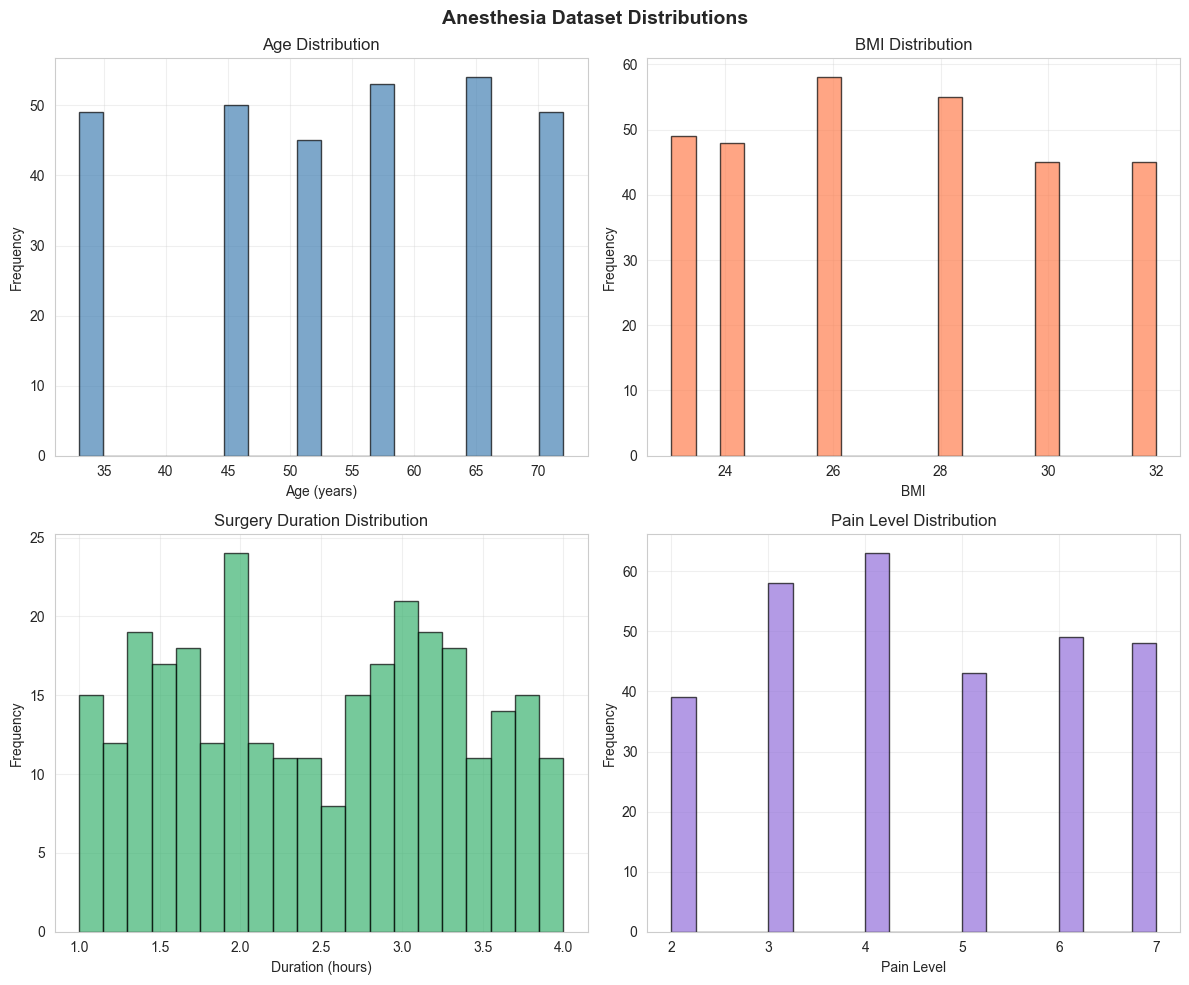

In [29]:
# 6a. 2x2 subplot grid of anesthesia distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Anesthesia Dataset Distributions', fontsize=14, fontweight='bold')

# Top-left: Age histogram
axes[0, 0].hist(anes['Age'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].grid(True, alpha=0.3)

# Top-right: BMI histogram
axes[0, 1].hist(anes['BMI'], bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('BMI')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('BMI Distribution')
axes[0, 1].grid(True, alpha=0.3)

# Bottom-left: Duration hours histogram
axes[1, 0].hist(anes['duration_hours'], bins=20, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Duration (hours)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Surgery Duration Distribution')
axes[1, 0].grid(True, alpha=0.3)

# Bottom-right: PainLevel histogram
axes[1, 1].hist(anes['PainLevel'], bins=20, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Pain Level')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Pain Level Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

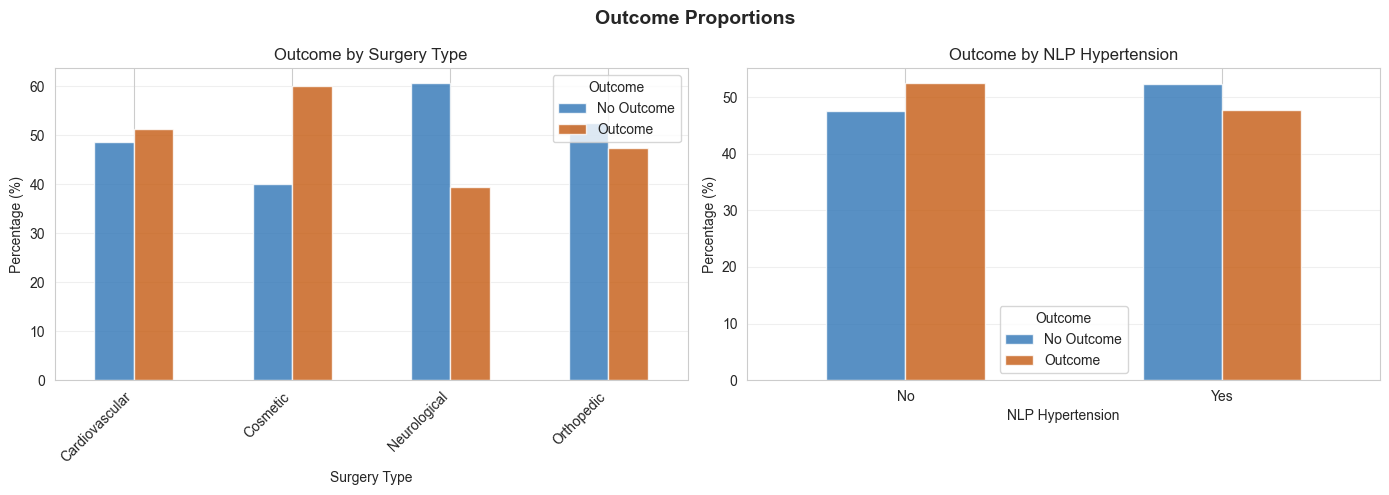

In [30]:
# 6b. Outcome proportion by SurgeryType and nlp_hypertension
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Outcome Proportions', fontsize=14, fontweight='bold')

# Left: Outcome by SurgeryType
outcome_by_surgery = pd.crosstab(anes['SurgeryType'], anes['Outcome'], normalize='index') * 100
outcome_by_surgery.plot(kind='bar', ax=axes[0], color=['#2E75B6', '#C55A11'], alpha=0.8)
axes[0].set_xlabel('Surgery Type')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Outcome by Surgery Type')
axes[0].legend(title='Outcome', labels=['No Outcome', 'Outcome'])
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Right: Outcome by nlp_hypertension
outcome_by_hypertension = pd.crosstab(anes['nlp_hypertension'], anes['Outcome'], normalize='index') * 100
outcome_by_hypertension.plot(kind='bar', ax=axes[1], color=['#2E75B6', '#C55A11'], alpha=0.8)
axes[1].set_xlabel('NLP Hypertension')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Outcome by NLP Hypertension')
axes[1].legend(title='Outcome', labels=['No Outcome', 'Outcome'])
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticklabels(['No', 'Yes'], rotation=0)

plt.tight_layout()
plt.show()

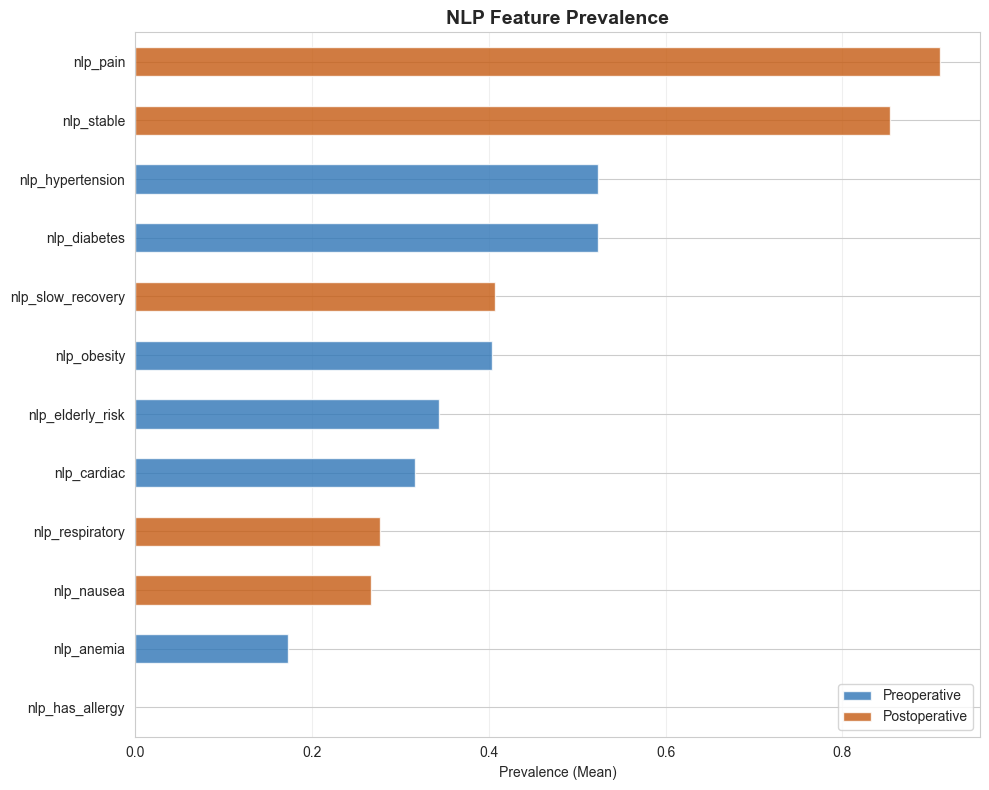

In [31]:
# 6c. NLP feature prevalence - horizontal bar chart
nlp_cols = [col for col in anes.columns if col.startswith('nlp_')]
nlp_prevalence = anes[nlp_cols].mean().sort_values()

# Color code: blue for preop, orange for postop
postop_features = ['nlp_pain', 'nlp_nausea', 'nlp_respiratory', 'nlp_slow_recovery', 'nlp_stable']
colors = ['#C55A11' if col in postop_features else '#2E75B6' for col in nlp_prevalence.index]

fig, ax = plt.subplots(figsize=(10, 8))
nlp_prevalence.plot(kind='barh', color=colors, alpha=0.8, ax=ax)
ax.set_xlabel('Prevalence (Mean)')
ax.set_title('NLP Feature Prevalence', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E75B6', alpha=0.8, label='Preoperative'),
    Patch(facecolor='#C55A11', alpha=0.8, label='Postoperative')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

=== AGE DISTRIBUTION COMPARISON ===
Anesthesia Age: min=33, max=72, mean=54.2
Heart Disease Age: min=28, max=77, mean=53.5
Overlap range: 33 to 72 years



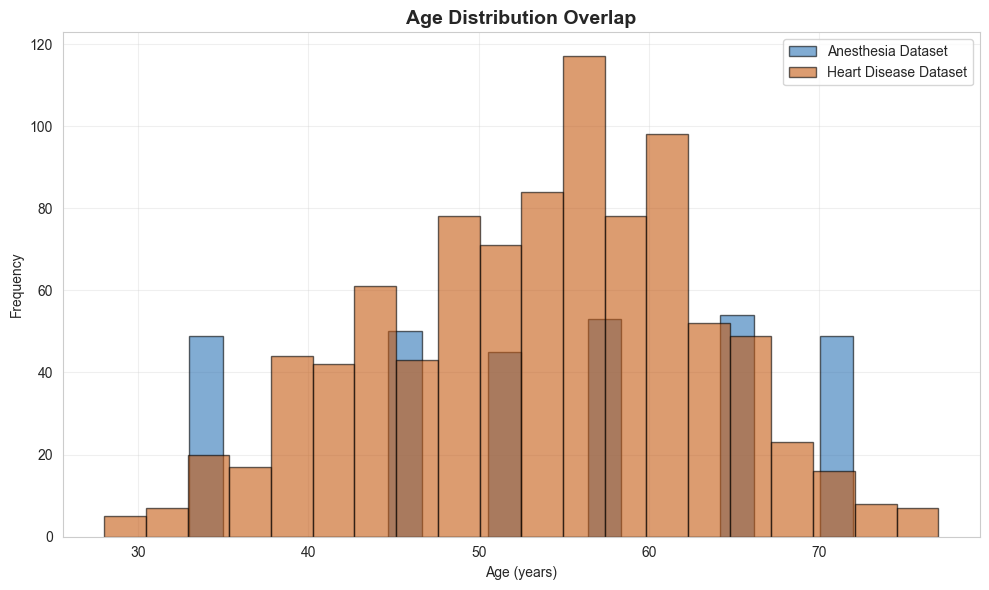

In [32]:
# 6d. Overlapping histograms - Age distributions
print("=== AGE DISTRIBUTION COMPARISON ===")
print(f"Anesthesia Age: min={anes['Age'].min()}, max={anes['Age'].max()}, mean={anes['Age'].mean():.1f}")
print(f"Heart Disease Age: min={heart['age'].min()}, max={heart['age'].max()}, mean={heart['age'].mean():.1f}")

overlap_min = max(anes['Age'].min(), heart['age'].min())
overlap_max = min(anes['Age'].max(), heart['age'].max())
print(f"Overlap range: {overlap_min} to {overlap_max} years\n")

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(anes['Age'], bins=20, alpha=0.6, label='Anesthesia Dataset', color='#2E75B6', edgecolor='black')
ax.hist(heart['age'], bins=20, alpha=0.6, label='Heart Disease Dataset', color='#C55A11', edgecolor='black')
ax.set_xlabel('Age (years)')
ax.set_ylabel('Frequency')
ax.set_title('Age Distribution Overlap', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

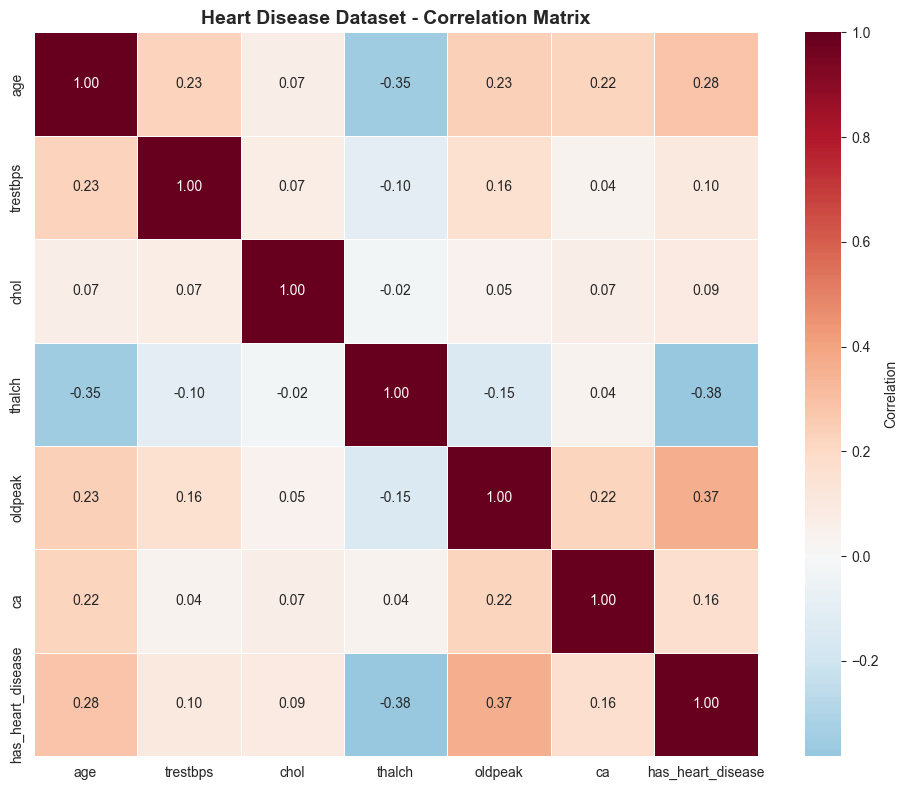

In [33]:
# 6e. Correlation heatmap for heart dataset
columns_to_plot = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'has_heart_disease']
correlation_matrix = heart[columns_to_plot].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='RdBu_r',
    center=0,
    fmt='.2f',
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'},
    ax=ax)
ax.set_title('Heart Disease Dataset - Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### ✏️ EDA Observations

Write at least 5 observations:

1. 
2. 
3. 
4. 
5. 

---
## Step 7 — Merge Datasets & Feature Fusion

We'll merge on age bins and define three feature sets for comparison.

In [ ]:
# Prompt for Claude Code:
#
# Merge datasets and define feature sets (3 code cells):
#
# 7a. Create 5-year age bins using pd.cut with bins=range(25, 80, 5).
#     Add 'age_bin' column to both anes (from 'Age') and heart (from 'age').
#     Print the bin distribution for each dataset sorted by index.
#
# 7b. Inner merge anes and heart on 'age_bin' with suffixes=('_surg', '_heart').
#     Print row counts for anes, heart, and merged. Print merge expansion factor
#     (merged rows / anes rows) and total column count.
#
# 7c. Define exactly these three feature lists:
#
#     structured_features = [
#         'Age', 'BMI', 'duration_hours', 'PainLevel', 'gender_encoded',
#         'anesthesia_general', 'has_complications',
#         'surgery_Cardiovascular', 'surgery_Cosmetic',
#         'surgery_Neurological', 'surgery_Orthopedic',
#     ]
#
#     nlp_features = [
#         'nlp_hypertension', 'nlp_diabetes', 'nlp_obesity', 'nlp_cardiac',
#         'nlp_anemia', 'nlp_elderly_risk', 'nlp_has_allergy',
#         'nlp_pain', 'nlp_nausea', 'nlp_respiratory', 'nlp_slow_recovery',
#         'nlp_stable',
#     ]
#
#     fused_features = structured_features + nlp_features
#
#     Print the count for each set. Assert every column exists in anes.

In [34]:
# 7a. Create 5-year age bins
print("=== CREATING AGE BINS ===\n")

anes['age_bin'] = pd.cut(anes['Age'], bins=range(25, 80, 5))
heart['age_bin'] = pd.cut(heart['age'], bins=range(25, 80, 5))

print("Anesthesia age bin distribution:")
print(anes['age_bin'].value_counts().sort_index())

print("\n\nHeart Disease age bin distribution:")
print(heart['age_bin'].value_counts().sort_index())

=== CREATING AGE BINS ===

Anesthesia age bin distribution:
age_bin
(25, 30]     0
(30, 35]    49
(35, 40]     0
(40, 45]    50
(45, 50]     0
(50, 55]    45
(55, 60]    53
(60, 65]    54
(65, 70]     0
(70, 75]    49
Name: count, dtype: int64


Heart Disease age bin distribution:
age_bin
(25, 30]      5
(30, 35]     27
(35, 40]     61
(40, 45]    103
(45, 50]    121
(50, 55]    196
(55, 60]    186
(60, 65]    139
(65, 70]     58
(70, 75]     20
Name: count, dtype: int64


In [36]:
# 7b. Inner merge on age_bin
print("=== MERGING DATASETS ===\n")

print(f"Rows before merge:")
print(f"  Anesthesia: {anes.shape[0]}")
print(f"  Heart: {heart.shape[0]}")

merged = pd.merge(anes, heart, on='age_bin', how='inner', suffixes=('_surg', '_heart'))

print(f"\nRows after merge:")
print(f"  Merged: {merged.shape[0]}")

expansion_factor = merged.shape[0] / anes.shape[0]
print(f"\nMerge expansion factor: {expansion_factor:.2f}x")
print(f"Total columns in merged dataset: {merged.shape[1]}")

=== MERGING DATASETS ===

Rows before merge:
  Anesthesia: 300
  Heart: 920

Rows after merge:
  Merged: 33637

Merge expansion factor: 112.12x
Total columns in merged dataset: 58


In [37]:
# 7c. Define feature sets
print("=== DEFINING FEATURE SETS ===\n")

structured_features = [
    'Age', 'BMI', 'duration_hours', 'PainLevel', 'gender_encoded',
    'anesthesia_general', 'has_complications',
    'surgery_Cardiovascular', 'surgery_Cosmetic',
    'surgery_Neurological', 'surgery_Orthopedic',
]

nlp_features = [
    'nlp_hypertension', 'nlp_diabetes', 'nlp_obesity', 'nlp_cardiac',
    'nlp_anemia', 'nlp_elderly_risk', 'nlp_has_allergy',
    'nlp_pain', 'nlp_nausea', 'nlp_respiratory', 'nlp_slow_recovery',
    'nlp_stable',
]

fused_features = structured_features + nlp_features

print(f"Structured features: {len(structured_features)}")
print(f"  {structured_features}\n")

print(f"NLP features: {len(nlp_features)}")
print(f"  {nlp_features}\n")

print(f"Fused features: {len(fused_features)}")
print(f"  (structured + nlp)\n")

# Verify all columns exist in merged dataset
missing_cols = [col for col in fused_features if col not in merged.columns]
if missing_cols:
    print(f"ERROR: Missing columns in merged dataset: {missing_cols}")
else:
    print("✓ All feature columns exist in merged dataset")

print(f"\nMerged dataset shape: {merged.shape}")

=== DEFINING FEATURE SETS ===

Structured features: 11
  ['Age', 'BMI', 'duration_hours', 'PainLevel', 'gender_encoded', 'anesthesia_general', 'has_complications', 'surgery_Cardiovascular', 'surgery_Cosmetic', 'surgery_Neurological', 'surgery_Orthopedic']

NLP features: 12
  ['nlp_hypertension', 'nlp_diabetes', 'nlp_obesity', 'nlp_cardiac', 'nlp_anemia', 'nlp_elderly_risk', 'nlp_has_allergy', 'nlp_pain', 'nlp_nausea', 'nlp_respiratory', 'nlp_slow_recovery', 'nlp_stable']

Fused features: 23
  (structured + nlp)

✓ All feature columns exist in merged dataset

Merged dataset shape: (33637, 58)


---
Step 8 — Statistical Testing

Before modeling, let's test whether NLP-extracted features are associated with outcomes.

In [ ]:
# Prompt for Claude Code:
#
# Statistical hypothesis testing (1 code cell):
#
# Chi-square tests (chi2_contingency on pd.crosstab) for these pairs:
#   - nlp_hypertension vs Outcome
#   - nlp_diabetes vs Outcome
#   - nlp_obesity vs Outcome
#   - nlp_cardiac vs Outcome
#
# Independent t-tests (ttest_ind) for:
#   - PainLevel grouped by nlp_hypertension (group 1 vs group 0)
#   - PainLevel grouped by nlp_diabetes (group 1 vs group 0)
#
# For each test, print: test name, statistic, p-value, and whether
# significant at p < 0.05. Also print group means for t-tests.
# Collect all results into a summary DataFrame called `results_df`.

In [42]:
# 8. Statistical hypothesis testing
print("=== STATISTICAL HYPOTHESIS TESTING ===\n")

# First, check which columns exist after merge
pain_col_name = 'PainLevel' if 'PainLevel' in merged.columns else 'PainLevel_surg'

test_results = []

# Chi-square tests for categorical associations with Outcome
chi_square_pairs = [
    ('nlp_hypertension', 'Outcome'),
    ('nlp_diabetes', 'Outcome'),
    ('nlp_obesity', 'Outcome'),
    ('nlp_cardiac', 'Outcome'),]

print("CHI-SQUARE TESTS (Categorical vs Outcome)")
print("=" * 70)

for col1, col2 in chi_square_pairs:
    contingency_table = pd.crosstab(merged[col1], merged[col2])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    significant = "Yes" if p_value < 0.05 else "No"

    print(f"\n{col1} vs {col2}")
    print(f"  Chi-square statistic: {chi2:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significant (p < 0.05): {significant}")

    test_results.append({
        'Test': f'Chi-square: {col1} vs {col2}',
        'Statistic': chi2,
        'P-value': p_value,
        'Significant': significant,
        'Type': 'Chi-square'})

# T-tests for continuous variable (PainLevel) by categorical groups
print("\n\nT-TESTS (PainLevel by NLP Feature)")
print("=" * 70)

t_test_pairs = [
    ('nlp_hypertension', pain_col_name),
    ('nlp_diabetes', pain_col_name),]

for feature, pain_col in t_test_pairs:
    group_0 = merged[merged[feature] == 0][pain_col].dropna()
    group_1 = merged[merged[feature] == 1][pain_col].dropna()

    t_stat, p_value = ttest_ind(group_0, group_1)
    significant = "Yes" if p_value < 0.05 else "No"

    print(f"\n{pain_col} grouped by {feature}")
    print(f"  Group 0 (absent): n={len(group_0)}, mean={group_0.mean():.2f}")
    print(f"  Group 1 (present): n={len(group_1)}, mean={group_1.mean():.2f}")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significant (p < 0.05): {significant}")

    test_results.append({
        'Test': f'T-test: {pain_col} by {feature}',
        'Statistic': t_stat,
        'P-value': p_value,
        'Significant': significant,
        'Type': 'T-test'})

# Create summary DataFrame
results_df = pd.DataFrame(test_results)
print("\n\nSUMMARY TABLE")
print("=" * 70)
print(results_df.to_string(index=False))

=== STATISTICAL HYPOTHESIS TESTING ===

CHI-SQUARE TESTS (Categorical vs Outcome)

nlp_hypertension vs Outcome
  Chi-square statistic: 10.2722
  P-value: 0.0014
  Significant (p < 0.05): Yes

nlp_diabetes vs Outcome
  Chi-square statistic: 10.2722
  P-value: 0.0014
  Significant (p < 0.05): Yes

nlp_obesity vs Outcome
  Chi-square statistic: 54.6066
  P-value: 0.0000
  Significant (p < 0.05): Yes

nlp_cardiac vs Outcome
  Chi-square statistic: 368.6096
  P-value: 0.0000
  Significant (p < 0.05): Yes


T-TESTS (PainLevel by NLP Feature)

PainLevel grouped by nlp_hypertension
  Group 0 (absent): n=16210, mean=4.53
  Group 1 (present): n=17427, mean=4.34
  T-statistic: 11.0090
  P-value: 0.0000
  Significant (p < 0.05): Yes

PainLevel grouped by nlp_diabetes
  Group 0 (absent): n=16210, mean=4.53
  Group 1 (present): n=17427, mean=4.34
  T-statistic: 11.0090
  P-value: 0.0000
  Significant (p < 0.05): Yes


SUMMARY TABLE
                                   Test  Statistic      P-value Sign

---
Step 9 — The Three-Way Model Comparison

This is the payoff. We train models on structured-only, NLP-only, and fused feature sets, then compare. **The key metric: does adding NLP features improve prediction?**

In [ ]:
# Prompt for Claude Code:
#
# Three-way model comparison (4 code cells):
#
# 9a. Set target = 'Outcome'. Create y from anes[target].
#     Build a dict `feature_sets` with keys 'Structured', 'NLP-only', 'Fused'
#     mapping to structured_features, nlp_features, fused_features.
#     Split anes[fused_features] into train/test with test_size=0.2,
#     stratify=y, random_state=42. Print sizes and class balance.
#
# 9b. Loop over each feature set and train both:
#     - LogisticRegression(max_iter=1000, random_state=42)
#     - RandomForestClassifier(n_estimators=100, random_state=42)
#     For each, compute: accuracy, weighted precision/recall/F1, AUC.
#     Store ROC curve data (fpr, tpr, auc) in a dict `roc_data` keyed
#     by '{feature_set} — {model_name}'.
#     Save the Fused RandomForest model as `fused_rf`.
#     Collect all metrics into `comparison_df` DataFrame and display it.
#
# 9c. Plot all 6 ROC curves on one figure (10x8).
#     Color by feature set: Structured=#2E75B6, NLP-only=#C55A11, Fused=#548235.
#     Line style by model: LogReg=solid, RandomForest=dashed.
#     Include diagonal random baseline. Legend in lower right.
#
# 9d. AUC bar chart: pivot comparison_df by Feature Set × Model for AUC.
#     Order: Structured, NLP-only, Fused. Add value labels on bars.
#     Draw horizontal line at 0.5 for random baseline.
#     Calculate NLP uplift = best Fused AUC − best Structured AUC.
#     Print the uplift prominently.

In [44]:
# 9a. Set up target, feature sets, and train/test split
print("=== THREE-WAY MODEL COMPARISON SETUP ===\n")

target = 'Outcome'
y = anes[target]

feature_sets = {
    'Structured': structured_features,
    'NLP-only': nlp_features,
    'Fused': fused_features}

# Verify all features exist
for name, features in feature_sets.items():
    missing = [f for f in features if f not in anes.columns]
    if missing:
        print(f"ERROR in {name}: Missing columns {missing}")
    else:
        print(f"✓ {name}: {len(features)} features")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
      anes[fused_features],
      y,
      test_size=0.2,
      stratify=y,
      random_state=42)

print(f"\n\nTrain/Test Split:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"\nClass balance (training):")
print(f"  {y_train.value_counts().to_dict()}")
print(f"\nClass balance (test):")
print(f"  {y_test.value_counts().to_dict()}")

=== THREE-WAY MODEL COMPARISON SETUP ===

✓ Structured: 11 features
✓ NLP-only: 12 features
✓ Fused: 23 features


Train/Test Split:
  Training set: 240 samples
  Test set: 60 samples

Class balance (training):
  {1: 120, 0: 120}

Class balance (test):
  {0: 30, 1: 30}


In [45]:
# 9b. Train models and collect metrics
print("=== TRAINING MODELS ===\n")

roc_data = {}
comparison_results = []
fused_rf = None

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)}

for feature_set_name, feature_list in feature_sets.items():
    print(f"\n{feature_set_name} Feature Set ({len(feature_list)} features)")
    print("=" * 60)

    # Get features for this set
    X_train_subset = X_train[feature_list]
    X_test_subset = X_test[feature_list]

    for model_name, model in models.items():
        # Train model
        model.fit(X_train_subset, y_train)

        # Get predictions and probabilities
        y_pred = model.predict(X_test_subset)
        y_pred_proba = model.predict_proba(X_test_subset)[:, 1]

        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        weighted_precision = report['weighted avg']['precision']
        weighted_recall = report['weighted avg']['recall']
        weighted_f1 = report['weighted avg']['f1-score']
        auc = roc_auc_score(y_test, y_pred_proba)

        # Get ROC curve data
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_data[f'{feature_set_name} — {model_name}'] = (fpr, tpr, auc)

        # Save fused RandomForest model
        if feature_set_name == 'Fused' and model_name == 'RandomForest':
            fused_rf = model

        print(f"\n{model_name}:")
        print(f"  Accuracy:   {accuracy:.4f}")
        print(f"  Precision:  {weighted_precision:.4f}")
        print(f"  Recall:     {weighted_recall:.4f}")
        print(f"  F1-score:   {weighted_f1:.4f}")
        print(f"  AUC:        {auc:.4f}")

        comparison_results.append({
            'Feature Set': feature_set_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': weighted_precision,
            'Recall': weighted_recall,
            'F1': weighted_f1,
            'AUC': auc})

comparison_df = pd.DataFrame(comparison_results)
print("\n\nCOMPARISON SUMMARY")
print("=" * 60)
print(comparison_df.to_string(index=False))

=== TRAINING MODELS ===


Structured Feature Set (11 features)

LogisticRegression:
  Accuracy:   0.5500
  Precision:  0.5501
  Recall:     0.5500
  F1-score:   0.5499
  AUC:        0.5089

RandomForest:
  Accuracy:   0.6000
  Precision:  0.6004
  Recall:     0.6000
  F1-score:   0.5996
  AUC:        0.6378

NLP-only Feature Set (12 features)

LogisticRegression:
  Accuracy:   0.4667
  Precision:  0.4665
  Recall:     0.4667
  F1-score:   0.4661
  AUC:        0.4617

RandomForest:
  Accuracy:   0.4667
  Precision:  0.4661
  Recall:     0.4667
  F1-score:   0.4643
  AUC:        0.4517

Fused Feature Set (23 features)

LogisticRegression:
  Accuracy:   0.5333
  Precision:  0.5335
  Recall:     0.5333
  F1-score:   0.5328
  AUC:        0.5444

RandomForest:
  Accuracy:   0.4500
  Precision:  0.4495
  Recall:     0.4500
  F1-score:   0.4486
  AUC:        0.5033


COMPARISON SUMMARY
Feature Set              Model  Accuracy  Precision   Recall       F1      AUC
 Structured LogisticRegression

=== PLOTTING ROC CURVES ===



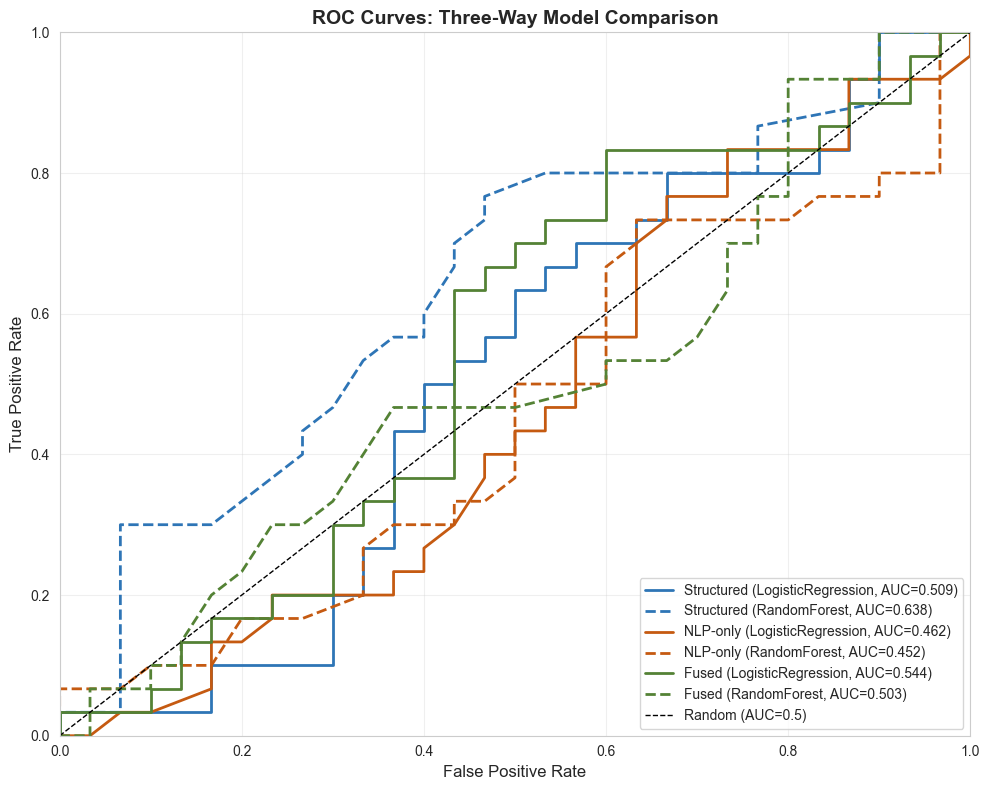

In [46]:
# 9c. Plot all 6 ROC curves
print("=== PLOTTING ROC CURVES ===\n")

fig, ax = plt.subplots(figsize=(10, 8))

# Define colors by feature set
colors = {
    'Structured': '#2E75B6',
    'NLP-only': '#C55A11',
    'Fused': '#548235'}

# Define line styles by model
line_styles = {
    'LogisticRegression': '-',
    'RandomForest': '--'}

# Plot ROC curves
for key, (fpr, tpr, auc) in roc_data.items():
    feature_set, model_name = key.split(' — ')
    color = colors[feature_set]
    linestyle = line_styles[model_name]

    ax.plot(
        fpr, tpr,
        color=color,
        linestyle=linestyle,
        linewidth=2,
        label=f'{feature_set} ({model_name}, AUC={auc:.3f})')

# Plot diagonal baseline
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC=0.5)')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Three-Way Model Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

=== AUC COMPARISON AND NLP UPLIFT ===



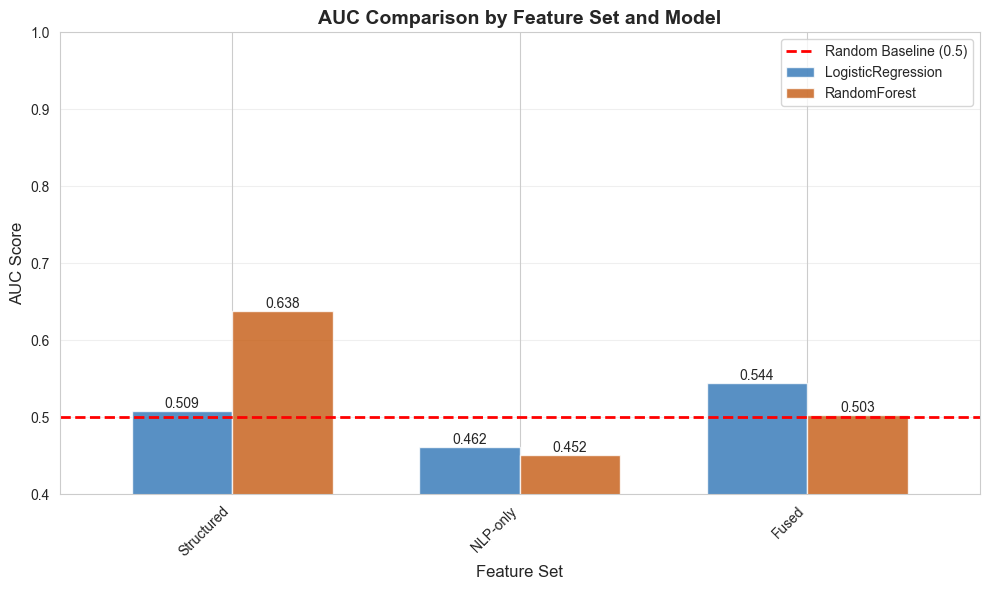



NLP UPLIFT ANALYSIS
Best Structured AUC:  0.6378
Best Fused AUC:       0.5444
NLP Uplift:           -0.0933 (-14.63%)


In [48]:
# 9d. AUC bar chart and NLP uplift calculation
print("=== AUC COMPARISON AND NLP UPLIFT ===\n")

# Pivot for AUC by Feature Set and Model
auc_pivot = comparison_df.pivot(index='Feature Set', columns='Model', values='AUC')
auc_pivot = auc_pivot.reindex(['Structured', 'NLP-only', 'Fused'])

fig, ax = plt.subplots(figsize=(10, 6))
auc_pivot.plot(kind='bar', ax=ax, color=['#2E75B6', '#C55A11'], alpha=0.8, width=0.7)

ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Random Baseline (0.5)')
ax.set_xlabel('Feature Set', fontsize=12)
ax.set_ylabel('AUC Score', fontsize=12)
ax.set_title('AUC Comparison by Feature Set and Model', fontsize=14, fontweight='bold')
ax.set_ylim([0.4, 1.0])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=10)

plt.tight_layout()
plt.show()

# Calculate NLP uplift
best_structured_auc = comparison_df[comparison_df['Feature Set'] == 'Structured']['AUC'].max()
best_fused_auc = comparison_df[comparison_df['Feature Set'] == 'Fused']['AUC'].max()
nlp_uplift = best_fused_auc - best_structured_auc

print(f"\n\nNLP UPLIFT ANALYSIS")
print("=" * 60)
print(f"Best Structured AUC:  {best_structured_auc:.4f}")
print(f"Best Fused AUC:       {best_fused_auc:.4f}")
print(f"NLP Uplift:           {nlp_uplift:+.4f} ({nlp_uplift/best_structured_auc*100:+.2f}%)")

---
## Step 10 — Feature Importance & Clinical Interpretation

In [ ]:
# Prompt for Claude Code:
#
# Feature importance visualization (1 code cell):
#
# Extract feature_importances_ from fused_rf (the Fused RandomForest
# model saved in Step 9b).
# Create a DataFrame with columns: feature, importance, source
# (source = 'NLP' if feature starts with 'nlp_', else 'Structured').
# Sort by importance ascending.
#
# Plot a horizontal bar chart (10x8) of all fused features.
# Color-code: blue (#2E75B6) for Structured, orange (#C55A11) for NLP.
# Add a legend using matplotlib.patches.Patch.
# Print how many NLP features appear in the top 10 most important.

=== FEATURE IMPORTANCE ANALYSIS ===



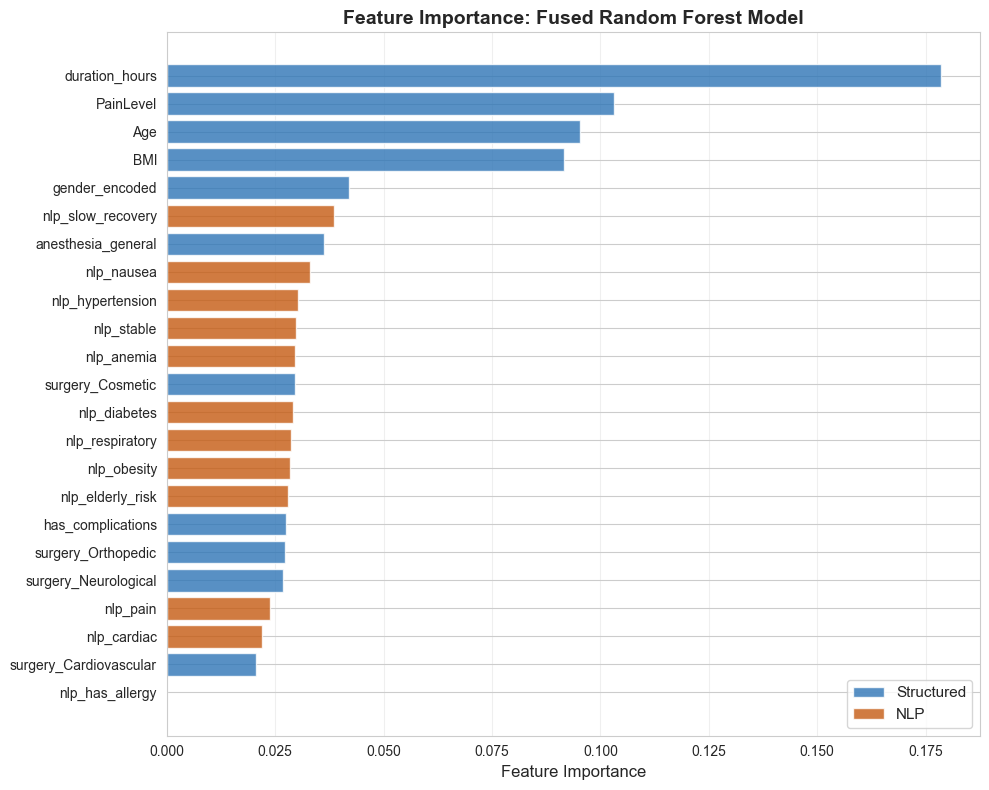


Top 10 Most Important Features:
           feature  importance     source
        nlp_stable    0.029846        NLP
  nlp_hypertension    0.030365        NLP
        nlp_nausea    0.033153        NLP
anesthesia_general    0.036180 Structured
 nlp_slow_recovery    0.038616        NLP
    gender_encoded    0.042029 Structured
               BMI    0.091653 Structured
               Age    0.095235 Structured
         PainLevel    0.103033 Structured
    duration_hours    0.178603 Structured


NLP Features in Top 10: 4 out of 10
Structured Features in Top 10: 6 out of 10


In [49]:
# 10. Feature importance visualization
print("=== FEATURE IMPORTANCE ANALYSIS ===\n")

# Extract feature importances from fused RandomForest model
feature_importances = fused_rf.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': fused_features,
    'importance': feature_importances})

# Add source column
importance_df['source'] = importance_df['feature'].apply(lambda x: 'NLP' if x.startswith('nlp_') else 'Structured')

# Sort by importance ascending (highest at bottom)
importance_df = importance_df.sort_values('importance', ascending=True)

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#C55A11' if src == 'NLP' else '#2E75B6' for src in importance_df['source']]
ax.barh(importance_df['feature'], importance_df['importance'], color=colors, alpha=0.8)

ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Feature Importance: Fused Random Forest Model', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E75B6', alpha=0.8, label='Structured'),
    Patch(facecolor='#C55A11', alpha=0.8, label='NLP')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.tight_layout()
plt.show()

# Analysis of NLP features in top 10
top_10 = importance_df.tail(10)
nlp_in_top_10 = (top_10['source'] == 'NLP').sum()

print(f"\nTop 10 Most Important Features:")
print(top_10[['feature', 'importance', 'source']].to_string(index=False))

print(f"\n\nNLP Features in Top 10: {nlp_in_top_10} out of 10")
print(f"Structured Features in Top 10: {10 - nlp_in_top_10} out of 10")

### ✏️ Interpretation

**Does NLP add value?** Quantify the uplift and explain what it means.

*Your answer:*

**Which NLP features contributed most?** Why do these make clinical sense?

*Your answer:*

**Synthetic data limitation:** Be honest about what this means for real-world applicability.

*Your answer:*

---
## Step 11 — NLP Pipeline Documentation & Error Analysis

### Pipeline Diagram

```
Raw Clinical Notes (2 unique values)
        │
        ▼
Note Enrichment (generate_preop_note / generate_postop_note)
        │  Uses: Age, BMI, SurgeryType, original note, Complications
        ▼
Enriched Notes (50+ unique variants)
        │
        ▼
Text Preprocessing (lowercase, clean punctuation, normalize whitespace)
        │
        ▼
Regex Entity Extraction (comorbidity_patterns + postop_patterns)
        │  Handles: synonyms, word boundaries, allergy negation
        ▼
NLP Feature Columns (binary flags: nlp_hypertension, nlp_diabetes, ...)
        │
        ▼
Validation (gold standard → precision / recall / F1 → error analysis → iterate)
        │
        ▼
Feature Fusion (structured_features + nlp_features → fused_features)
        │
        ▼
Three-Way Model Comparison → NLP Uplift Quantified
```

### Scalability Discussion

**Would this regex pipeline work on 10,000 real clinical notes?**

*Your answer:*

**What would a production NLP system need beyond regex?**

Consider: negation detection (NegEx), clinical NER models (MedSpaCy, Clinical BERT), abbreviation expansion, section detection (HPI vs. Assessment vs. Plan).

*Your answer:*

### Rule-Based vs. ML-Based NLP

| Aspect | Rule-Based (our regex) | ML-Based (spaCy / BERT) |
|--------|------------------------|-------------------------|
| Setup effort | | |
| Accuracy on known patterns | | |
| Handling new/unseen text | | |
| Negation handling | | |
| Maintenance | | |
| Speed | | |

*(Fill in the table with your assessment)*

---
## Step 12 — Conclusion & Limitations

### Key Findings

*(Fill in after completing the project)*

1. 
2. 
3. 
4. 
5. 

### Limitations

- The enriched notes were generated FROM structured data, so NLP features are partially derivative. In a real system with genuine clinical notes, NLP would capture information (medication dosages, family history, social history) that doesn't exist in any structured field.
- The dataset merge is approximate (age-binned, not patient-matched).
- The anesthesia dataset is small (300 patients).
- *(Add your own additional limitations)*

### Future Work

- 
- 
- 

---

*Go back to the top and fill in the Executive Summary now that you know your results.*